<a id="top"></a>
# Cloud-Filtered Custom Mosaics

<hr>

*Notebook compatible with DE Africa Collection 1 Sandbox

# Notebook Summary

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

Median = midpoint of spectral data
Geomedian = Australian median product with improved spectral consistency
Most-Recent = most-recent clear pixel
Max-NDVI = maximum vegetation response

Users should review the ["Cloud_Statistics" notebook](DCAL_Cloud_Statistics.ipynb) for more 
information about the cloud statistics for any given temporal and spatial combination. 
An understanding of the underlying data is important for creating a valid mosaic for further analyses.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Create Mosaics](#mosaics)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Load Data Cube Configuration
import datacube
# Enable importing of utilities.
import sys
import os

# Supress Warnings.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from odc.ui import DcViewer
from datacube.helpers import write_geotiff


#import DE Africa script
sys.path.append('../Scripts')
from deafrica_plotting import display_map
from deafrica_plotting import rgb


#import DCAL utility scripts
sys.path.append('../DCAL_utils')
from plotter_utils import figure_ratio, retrieve_or_create_fig_ax, intersection_threshold_plot, month_names_long
from dc_time import _n64_to_datetime
from clean_mask import landsat_qa_clean_mask
from dc_mosaic import create_median_mosaic, create_hdmedians_multiple_band_mosaic, create_mosaic, create_max_ndvi_mosaic
#create mosaic is the one that fills no-data with most recent/least resent clear observation, but possibly we have the wrong script


In [2]:
dc = datacube.Datacube(app="DCAL Custion Mosaics")

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
4,LANDSAT_8,ls8_usgs_sr_scene


## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

**Visualize the available area**

In [4]:
DcViewer(dc=dc,
         products = ['ls8_usgs_sr_scene'],
         time='2017',
         center=(0.565, 38.007),
         zoom=4)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

#Lake Chad
# latitude = (13.7789, 14.2789)
# longitude = (13.1403, 12.5403)

#mt Kenya
latitude = (-0.2678, -0.5067)
longitude = (37.4263, 37.7737)

# Time Period
time_extents = ('2015-01-01', '2015-06-01')

**Visualize the selected area**

In [6]:
display_map(longitude,latitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [7]:
landsat_dataset = dc.load(product = 'ls8_usgs_sr_scene',
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                          y = latitude,
                          x = longitude,
                          time = time_extents,
                          output_crs='EPSG:6933',
                          resolution=(-30,30)) 

In [8]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:   (time: 26, x: 1119, y: 1017)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-05T07:42:49.985922 ... 2015-05-29T07:42:15.513778
  * y         (y) float64 -3.416e+04 -3.418e+04 ... -6.460e+04 -6.464e+04
  * x         (x) float64 3.611e+06 3.611e+06 3.611e+06 ... 3.645e+06 3.645e+06
Data variables:
    red       (time, y, x) int16 290 285 283 291 302 ... -9999 -9999 -9999 -9999
    green     (time, y, x) int16 486 447 463 487 481 ... -9999 -9999 -9999 -9999
    blue      (time, y, x) int16 201 183 174 192 199 ... -9999 -9999 -9999 -9999
    nir       (time, y, x) int16 3630 3416 3639 3841 ... -9999 -9999 -9999 -9999
    swir1     (time, y, x) int16 1671 1576 1596 1701 ... -9999 -9999 -9999 -9999
    swir2     (time, y, x) int16 702 668 674 708 710 ... -9999 -9999 -9999 -9999
    pixel_qa  (time, y, x) uint16 322 322 322 322 322 322 322 ... 1 1 1 1 1 1 1
Attributes:
    crs:      EPSG:6933

>### Masking out Clouds

In [9]:
#load cloud mask and apply to dataset
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform='LANDSAT_8')
cleaned_dataset = landsat_dataset.where(cloud_mask)

## <span id="mosaics">Create Mosaics [&#9652;](#top)</span>

> **Median Mosaic**  
>  Masks clouds from imagery using the median-valued cloud-free pixels in the time series.
>  More specifically, each band (e.g. red) of each pixel is assigned its median across time.
>  So this mosaic method generates values that are not in the dataset.

In [10]:
cleaned_dataset

<xarray.Dataset>
Dimensions:   (time: 26, x: 1119, y: 1017)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-05T07:42:49.985922 ... 2015-05-29T07:42:15.513778
  * y         (y) float64 -3.416e+04 -3.418e+04 ... -6.460e+04 -6.464e+04
  * x         (x) float64 3.611e+06 3.611e+06 3.611e+06 ... 3.645e+06 3.645e+06
Data variables:
    red       (time, y, x) float64 290.0 285.0 283.0 291.0 ... nan nan nan nan
    green     (time, y, x) float64 486.0 447.0 463.0 487.0 ... nan nan nan nan
    blue      (time, y, x) float64 201.0 183.0 174.0 192.0 ... nan nan nan nan
    nir       (time, y, x) float64 3.63e+03 3.416e+03 3.639e+03 ... nan nan nan
    swir1     (time, y, x) float64 1.671e+03 1.576e+03 1.596e+03 ... nan nan nan
    swir2     (time, y, x) float64 702.0 668.0 674.0 708.0 ... nan nan nan nan
    pixel_qa  (time, y, x) float64 322.0 322.0 322.0 322.0 ... nan nan nan nan
Attributes:
    crs:      EPSG:6933

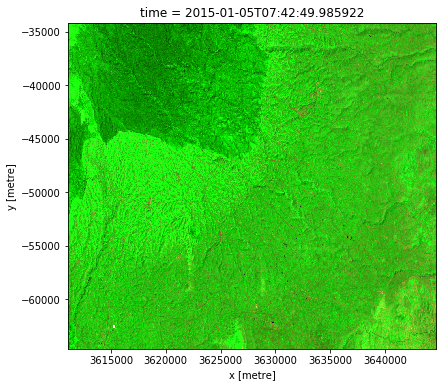

In [11]:
rgb(cleaned_dataset, bands=['swir2', 'nir', 'green'], index=0)

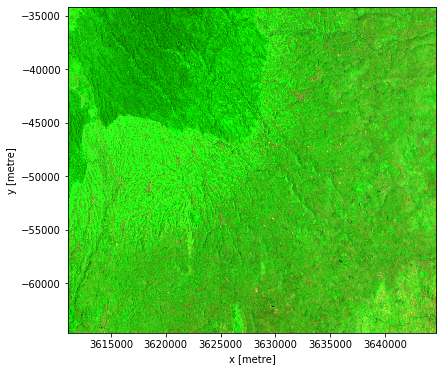

In [12]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(median_composite, bands=['swir2', 'nir', 'green'])


> **Geomedian Mosaic**  
>  Masks clouds from imagery using the geomedian-valued cloud-free pixels in the time series, which maintains the spectral band relationships. 
> That is, this is a median through time for all bands considered collectively rather than separately, as is the case in a median mosaic.
> This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 
<br><br>
For more information, see the following paper: High-Dimensional Pixel Composites from Earth Observation Time Series, by, Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

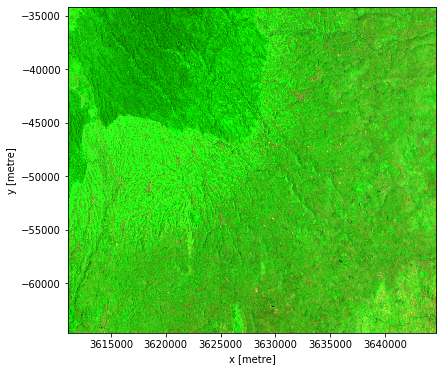

In [13]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

geomedian_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(geomedian_composite, bands=['swir2', 'nir', 'green'])

> **Most Recent and Least Recent Mosaic**  
>  Masks clouds from imagery using the most or least recent cloud-free pixels in the time series. 

**Most Recent Mosaic**

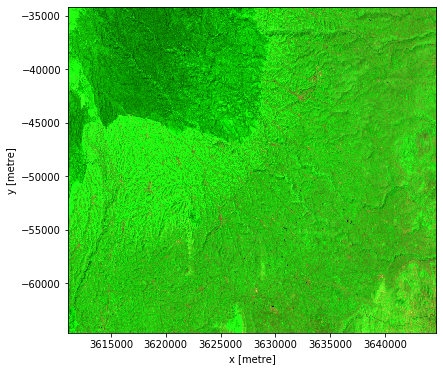

In [14]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)
rgb(most_recent_composite, bands=['swir2', 'nir', 'green'])

**Least Recent Mosaic**

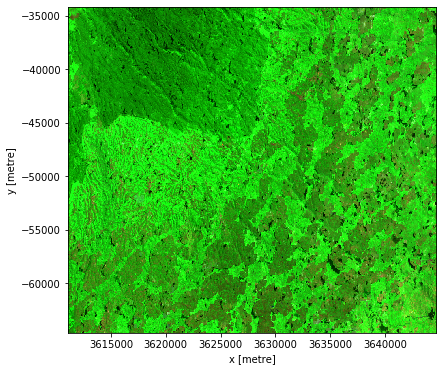

In [15]:
least_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values, reverse_time=True)
rgb(least_recent_composite, bands=['swir2', 'nir', 'green'])

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series. 

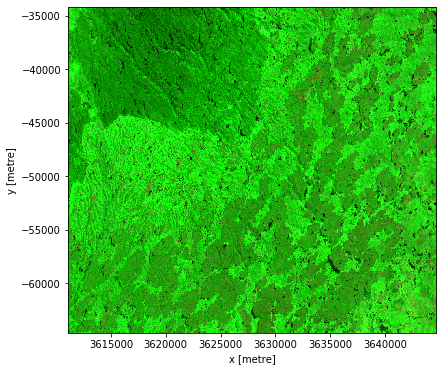

In [16]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask.values)
rgb(max_ndvi_composite, bands=['swir2', 'nir', 'green'])

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [17]:
#copy attributes from original dataset to median for export
median_composite.attrs = landsat_dataset.attrs

#set output directory, if it dosn't exist create
output_dir = '../output/geotiffs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
#Set file name
# Change the name of the output file, or it will be overwritten for each run 
output_filename =  output_dir + '/DEMO_median_composite.tif' 
    
#run command to save to file
write_geotiff(output_filename, median_composite)


## Notes on modifications made moving from ARDC to DE Africa

- Replace dc.load fuction with DE Africa load
- Move all module imports to start of notebook
- Removed code to view extent of datacube replaced with mapviewer that can be used to visualise spatial extent of data
- Changed rgb plot fuction to DE Africa rgb plot fuction
- replaced save to geotiff fuction with DE Africa fuction